# Tutorial 8: Drivability Checks for Truck

This tutorial demonstrates how to apply the drivability checker if a semi-trailer truck is involved.

Imports & helper functions:

In [1]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

time_step_size = 10


def plot_scenario(scenario, trajectory=None, vehicle_id=None, small_plot=False):
    plot_limits = [0, 150, 0, 600]
    if small_plot:
        plot_limits = [-60, 60, -40, 40]

    additional_draw_params = {}
    if vehicle_id is not None:
        additional_draw_params = {'focus_obstacle_id': vehicle_id}

    num_plots = 1
    if trajectory is not None:
        num_plots = int(len(trajectory.state_list) / time_step_size)

    for i in range(0, num_plots):
        rnd = MPRenderer(figsize=(25, 10), plot_limits=plot_limits)
        display.clear_output(wait=True)
        scenario.draw(rnd, draw_params={'time_begin': i * time_step_size, **additional_draw_params})
        rnd.render()
        plt.show()

## 1. Setup scenario

### a) Load Ego-Vehicle

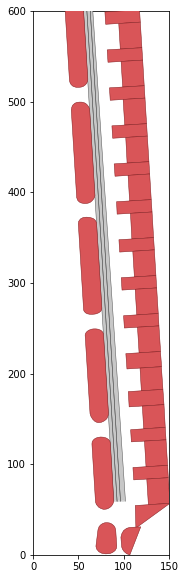

In [2]:
file_path = "ZAM_Loading_Bay-1_1_T.xml"

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario
rnd = MPRenderer(figsize=(25, 10), plot_limits=[0, 150, 0, 600])
display.clear_output(wait=True)
# plot the scenario at different time step
scenario.draw(rnd, draw_params={'time_begin': 0})
# plot the planning problem set
rnd.render()
plt.show()

### b) Create truck as dynamic obstacle

In [3]:
# import necessary classes from different modules
from commonroad.geometry.shape import ShapeGroup, Rectangle
from commonroad.scenario.obstacle import DynamicObstacle, ObstacleType
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

# modify the default parameters of np.load
np.load.__defaults__ = (None, True, True, 'ASCII')
states = list(np.load("trajectory.npy"))
# restore the default parameters of np.load
np.load.__defaults__ = (None, False, True, 'ASCII')

# create the trajectory of the obstacle, starting at time step 1
ego_id = scenario.generate_object_id()
trajectory = Trajectory(0, states)
base_shapes_of_truck = [Rectangle(5.875, 2.50), Rectangle(12.74, 2.46)]
wheelbase_lengths=[3.6, 8.755]
truck_shape = ShapeGroup(base_shapes_of_truck)
trajectory_prediction = TrajectoryPrediction(trajectory, truck_shape, wheelbase_lengths=wheelbase_lengths)

ego_truck = DynamicObstacle(ego_id,
                            ObstacleType.TRUCK,
                            truck_shape,
                            trajectory.state_list[0],
                            trajectory_prediction)

print(trajectory.state_list[0])


position= [ 67.03089285 507.83362306]
orientation= 1.6326086913133269
velocity= 1.0
steering_angle= 0.04704306722989684
time_step= 0
hitch= -0.00021940116141056626



### c) Create static obstacles

In [4]:
from commonroad.scenario.trajectory import State
from commonroad.scenario.obstacle import StaticObstacle

id_1 = scenario.generate_object_id()
# obstacle at the bottom left
static_obstacle_1 = StaticObstacle(id_1, ObstacleType.CAR, Rectangle(5, 3),
                                   State(position=np.array([67., 530.]), orientation=1.6, time_step=0))
scenario.add_objects(static_obstacle_1)

id_2 = scenario.generate_object_id()
# obstacle is placed to the right of the end position of the truck
position_2 = trajectory.state_list[-1].position
position_2[0] += 16  # TODO: change to enforce collision with this obstacle
static_obstacle_for_trailer_collision = StaticObstacle(id_2, ObstacleType.CAR, Rectangle(5, 3),
                                                       State(position=position_2, orientation=1.6, time_step=0))
scenario.add_objects(static_obstacle_for_trailer_collision)

id_3 = scenario.generate_object_id()
# get truck position with largest y-value
position_id = max(range(len(trajectory.state_list)), key=lambda i: trajectory.state_list[i].position[1])
# obstacle is placed on top of the "highest" position of the truck
position_3 = trajectory.state_list[position_id].position
position_3[1] += 6  # TODO: change to enforce collision with this obstacle
static_obstacle_for_truck_collision = StaticObstacle(id_3, ObstacleType.CAR, Rectangle(5, 3),
                                                     State(position=position_3, orientation=1.6, time_step=0))
scenario.add_objects(static_obstacle_for_truck_collision)

id_4 = scenario.generate_object_id()
# little hack for finding position of the truck's last turn; obstacle is placed below there
position_4 = next(s.position for s in reversed(trajectory.state_list) if abs(s.position[1] - position_2[1]) > 0.5)
position_4[1] -= 4.5 # TODO: increase subtracted offset for avoiding the collision
position_4[0] += 2
static_obstacle_for_full_collision = StaticObstacle(id_4, ObstacleType.CAR, Rectangle(5, 3),
                                                    State(position=position_4, orientation=2.4, time_step=0))
scenario.add_objects(static_obstacle_for_full_collision)

## 2. Collision checking

In [5]:
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object

cc = create_collision_checker(scenario)

ego_vehicle_co = create_collision_object(ego_truck)

res = cc.collide(ego_vehicle_co)
print('Collision between the ego vehicle and other static/dynamic obstacles: %s' % res)

Collision between the ego vehicle and other static/dynamic obstacles: True


In [6]:
scenario.add_objects(ego_truck)  # this is necessary for plotting the truck

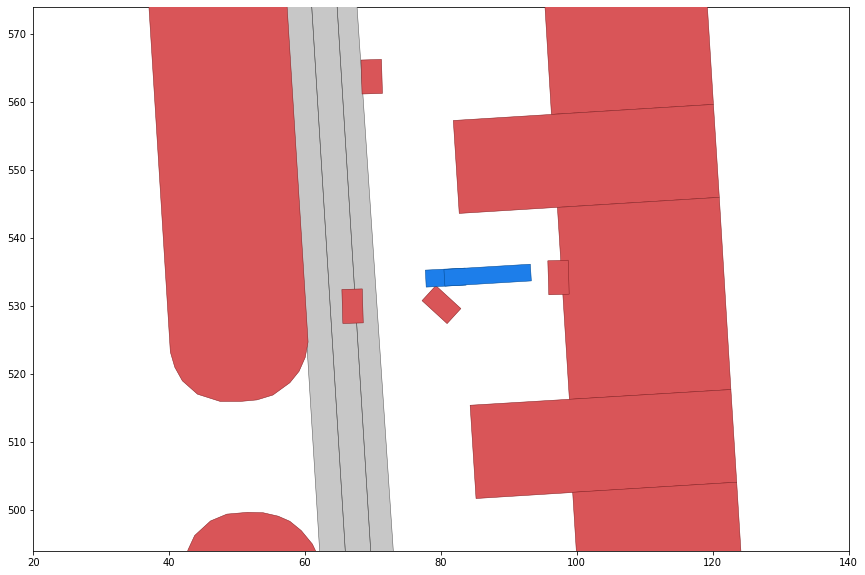

In [7]:
plot_scenario(scenario, trajectory, ego_id, small_plot=True)

## 2. Feasibility Checking

In [8]:
from commonroad_dc.feasibility import feasibility_checker
from commonroad.common.solution import VehicleType
from commonroad_dc.feasibility.vehicle_dynamics import VehicleDynamics

dt = scenario.dt
vehicle_dynamics = VehicleDynamics.KST(VehicleType.TRUCK)

# check feasibility of planned trajectory for the given vehicle model
feasible, reconstructed_inputs = feasibility_checker.trajectory_feasibility(trajectory, vehicle_dynamics, dt, e=np.array([9e-2, 9e-2, 9e-2]), maxiter=200)
print('The planned trajectory is feasible: %s' % feasible)

The planned trajectory is feasible: False


It turns out that the trajectory is not feasible regarding the truck kinematics. For checking where the trajectory is exactly wrong, the longest feasible prefix of it can be simulated, which is returned by the ```feasibility_checker.trajectory_feasibility(...)``` in an approximate manner.

The simulation suggests that the backwards-acceleration is too abrupt for the truck.

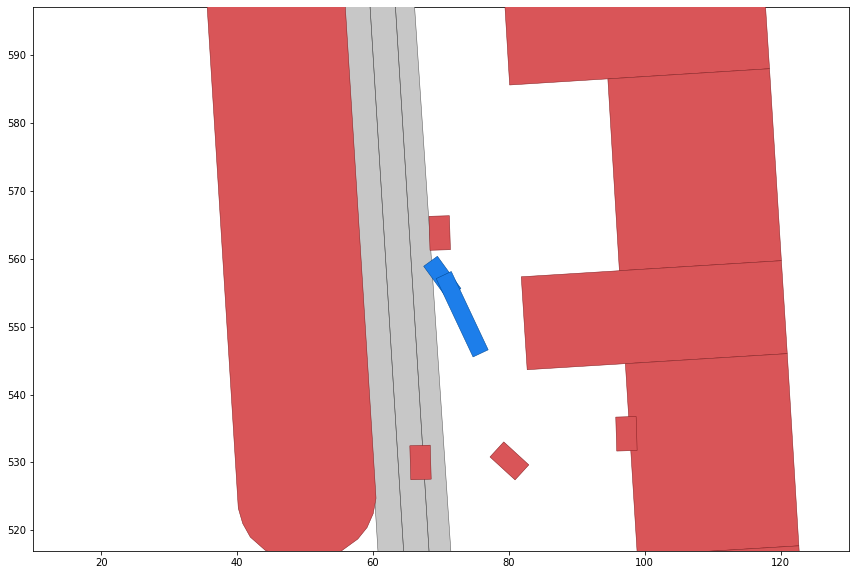

In [9]:
plot_scenario(scenario, reconstructed_inputs, ego_id, small_plot=True)

##  3. Road compliance

Number of boundary elements: 7


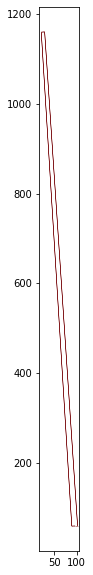

In [10]:
from commonroad_dc.boundary import boundary

road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles', open_lane_ends=False)

rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_rectangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % road_boundary_sg_rectangles.size())

In [11]:
from commonroad.geometry.shape import shape_group_occupancy_shape_from_state
from commonroad_dc import pycrcc


def create_tvobstacle(state_list):
    tvo=pycrcc.TimeVariantCollisionObject(0)
    for state in state_list:
        shape_group = shape_group_occupancy_shape_from_state(base_shapes_of_truck, state, wheelbase_lengths)
        pycrcc_shape_group = pycrcc.ShapeGroup()
        for shape in shape_group.shapes:
            pycrcc_shape_group.add_shape(pycrcc.RectOBB(shape.length / 2, shape.width / 2, shape.orientation, shape.center[0],shape.center[1]))
        tvo.append_obstacle(pycrcc_shape_group)
    return tvo

co = create_tvobstacle(trajectory.state_list)

In [12]:
from commonroad_dc.collision.trajectory_queries import trajectory_queries

preprocessed_trajectory, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
if(err):
    raise Exception("trajectory preprocessing error")

print(len(trajectory.state_list))
print(preprocessed_trajectory.time_end_idx())

1573
1572


In [13]:
ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)

first_time_step_of_collision = -1
if ret[0] == -1:
    print('No collision with the road boundary')
else:
    first_time_step_of_collision = ret[0]
    print('First time step of collision: %s' % first_time_step_of_collision)

First time step of collision: 279


Note, that currently the collision check is done using an axis-aligned bounding box around all shapes of the shape-group.

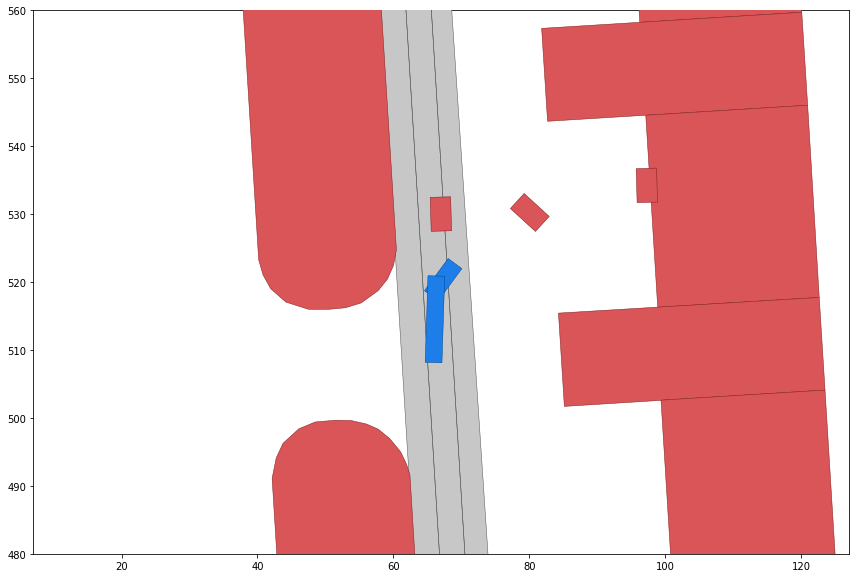

In [14]:
plot_scenario(scenario, Trajectory(0, trajectory.state_list[0:first_time_step_of_collision]), ego_id, small_plot=True)

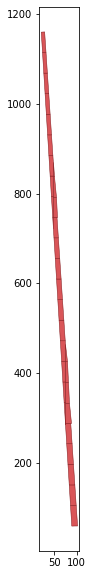

In [15]:
total_length = base_shapes_of_truck[0].length + base_shapes_of_truck[1].length
max_cell_width = total_length * 1.5
max_cell_height = total_length * 2.5

road_boundary_sg_polygons_grid=boundary.create_road_polygons(scenario, method='whole_polygon_tiled', max_cell_width=max_cell_width, max_cell_height=max_cell_height,triangulate=False)


# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
road_boundary_sg_polygons_grid.draw(rnd, draw_params={'draw_mesh': False})
rnd.render()

In [16]:
ret=trajectory_queries.trajectories_enclosure_polygons_static([preprocessed_trajectory], road_boundary_sg_polygons_grid, method='grid', num_cells=32, enable_verification=False)
if ret[0] == -1:
    print('The trajectory is completely enclosed')
else:
    print('First time step of incomplete enclosure: %s' % ret[0])

# TODO: this is not implemented yet; see collision/src/solvers/trajectory_queries.cc > trajectories_enclosure_polygons_static_grid(...)

ValueError: the trajectory for polygon enclosure checks can consist only of OBB or AABB boxes